In [1]:
from saber.cnn_tools import *
from saber.data_tools import *

from keras import backend as K
from keras.models import load_model

import os
import sys
import time
import numpy as np
import json

from intern import array

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
%matplotlib inline

Using TensorFlow backend.
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

In [2]:
print(f"GPU is enabled: {tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)}")

GPU is enabled: True


## Load a small chunk of data

Setup a BossRemote, select our channel, and cutout a small chunk of data. Here, for speed we'll only download a 256x256x16 chunk

In [3]:
# Save a cutout to a numpy array in ZYX order:
em = array("bossdb://Kasthuri/em/images")
x_test = em[864:880, 10240:11264, 6144:7168]

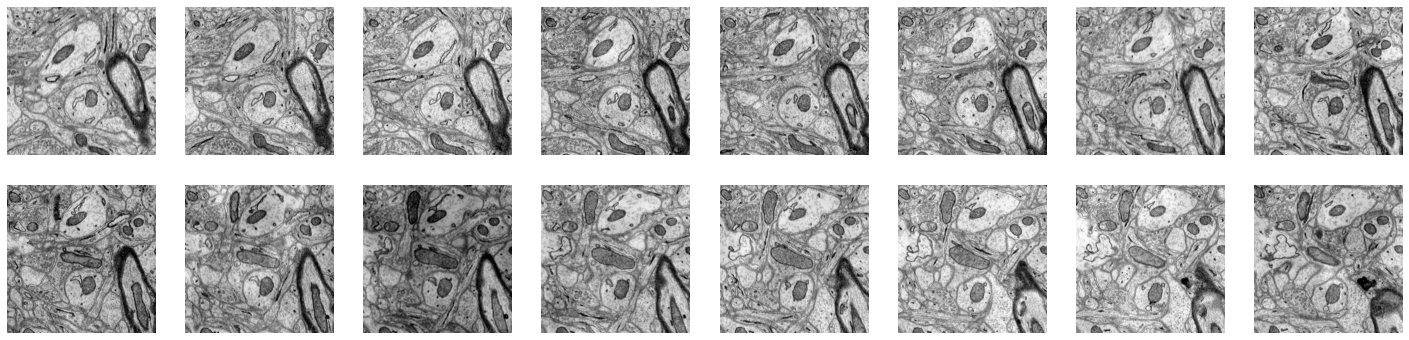

<Figure size 432x288 with 0 Axes>

In [4]:
# Data is in zyx
fig=plt.figure(figsize=(25, 6));
columns = 8
rows = 2
for i in range(1, columns*rows + 1):
    fig.add_subplot(rows, columns, i);
    plt.imshow(x_test[i-1, :, :], cmap='gray', vmin=0, vmax=255);
    plt.axis('off');
plt.show();
plt.tight_layout();

## Prepare the data
We're using some existing code that has all sorts of undocumented requirements. Let's just do what is recommended by reshaping and rescaling the data

In [5]:
x_test = x_test[:, np.newaxis, :, :]

# Data must be [slices, chan, row, col] (i.e. [Z, chan, Y, X])
x_test = x_test.astype(np.float32)
print('Input size {}'.format(x_test.shape))

Input size (16, 1, 1024, 1024)


In [6]:
# Pixel values must be in [0,1]
if x_test.max() > 1.0:
    x_test /= 255.

## Load the Modal
Next, we create a u-net model using Keras and load pre-trained wieghts. These weights were trained by JHU/APL and are available via their GitHub repo as indicated in a Dockerfile they use: (https://github.com/aplbrain/saber/blob/master/saber/i2g/detection/Dockerfile#L45)

In [7]:
width = 256
height = 256
tile_size = (width, height)
z_step = 1
output_file = "../output/untracked/result.npy"

np.random.seed(9999)
K.common.set_image_dim_ordering('th')

# Load model
model = create_unet((1, int(width), int(height)))
model.load_weights('../input/membrane_weights.hdf5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Classify images
Now we run images through the network. This will result in probability images from 0-255 indicating the probability that a pixel is a membrane (or synapse). You can then use this to threshold and classify pixels.

In [8]:
tic0 = time.time()
y_hat = np.zeros(x_test.shape)
for i in range(0, x_test.shape[0], z_step):
    y_hat[i:i+z_step, ...] = deploy_model(x_test[i:i+z_step, ...], model)

print('Total time to process entire volume: {}'.format(time.time() - tic0))

Total time to process entire volume: 3.2856459617614746


In [9]:
# Reshape for output
y_hat = np.squeeze(np.transpose(y_hat, (3, 2, 0, 1)))
y_hat = np.floor(y_hat*255)
with open(output_file, 'wb') as f:
    np.save(f, y_hat)

# Reshape the input so we can plot better
x_test_t = np.squeeze(np.transpose(x_test, (3, 2, 0, 1)))

## Plot some results
Finally, let's plot our image data and probability images together and see how we've done!

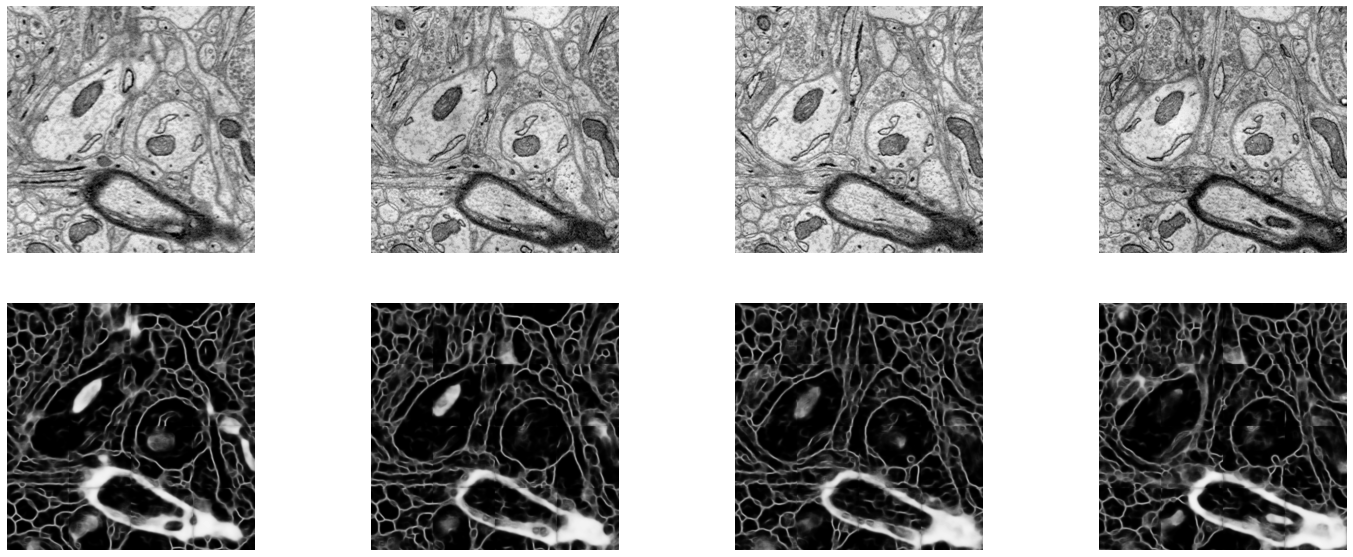

<Figure size 432x288 with 0 Axes>

In [10]:
# Plot some results
start_index = 0

fig=plt.figure(figsize=(25, 10));
columns = 4
rows = 2
for i in range(1, columns*rows + 1):
    fig.add_subplot(rows, columns, i);
    if i <= columns:
        plt.imshow(x_test_t[:, :, i-1], cmap='gray', vmin=0, vmax=1);
        plt.axis('off');
    else:
        plt.imshow(y_hat[:, :, i-5], cmap='gray', vmin=0, vmax=255);
        plt.axis('off');
plt.show();
plt.tight_layout();
